## Imports

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
import keras.utils as image
from PIL import Image

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
!pip install --upgrade --no-cache-dir --quiet gdown

## Download e preparação do dataset

In [ ]:
!gdown "15d98V1hjFOKv9jXOUPA8zcL3fyJO19D_"

Downloading...
From (uriginal): https://drive.google.com/uc?id=15d98V1hjFOKv9jXOUPA8zcL3fyJO19D_
From (redirected): https://drive.google.com/uc?id=15d98V1hjFOKv9jXOUPA8zcL3fyJO19D_&confirm=t&uuid=282b2a4c-de82-4236-9706-5f61bfdd648d
To: /content/data.zip
100% 1.27G/1.27G [00:22<00:00, 57.3MB/s]


In [ ]:
!rm -rf data
!unzip -qq data.zip

In [ ]:
!mv data/2/*.png data/1
!mv data/3/*.png data/1

!rm -rf data/2 data/3

In [ ]:
!find data/1 -type f -print0 | sort -zR | tail -zn +1001 | xargs -0 rm

In [ ]:
!ls data/1 | wc -l

1000


In [ ]:
files = []
folder = 'data'

for folder in os.listdir(folder):
    if folder != ".DS_Store":
        for file in os.listdir(f"data/{folder}"):
            files.append({"path": f"{folder}/{file}", "class": folder})

data = pd.DataFrame(files)

In [ ]:
data["image"] = data["path"].apply(lambda x: np.expand_dims(image.img_to_array(image.load_img(f"data/{x}").convert("L").resize((112, 112))), axis=-1))

data.head()

,path,class,image
0,1/1966101_b6defddee2673fc598d60aebcb2abce0.png,1,"[[[[255.]], [[255.]], [[255.]], [[255.]], [[25..."
1,1/4294730_3e80523cc3d2180a3599678dc0a1b63d.png,1,"[[[[255.]], [[255.]], [[255.]], [[255.]], [[25..."
2,1/653998_581d4d4ef9272006f799f809a5e2bf5d.png,1,"[[[[255.]], [[255.]], [[255.]], [[255.]], [[25..."
3,1/3748448_2a6c90285d8b30f9a1c4ecee17d14716.png,1,"[[[[255.]], [[255.]], [[255.]], [[255.]], [[25..."
4,1/1199548_5e57f1f46acf77d64e76f2f44c31bb96.png,1,"[[[[255.]], [[255.]], [[255.]], [[255.]], [[25..."


In [ ]:
# data.to_csv('data.csv')

## Divisão em treino, teste e validação

0 = bem-te-vi
1 = gaviao-carijo
2 = corujinha-do-mato
3 = sabia-laranjeira 

In [ ]:
X = np.array(data["image"].tolist())
y = np.array(data["class"].tolist()).astype('float32')

X = np.stack(X, axis=0)
X /= 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Modelo

In [ ]:
input_shape = (112, 112, 1)

# model 3 - Test Loss: 0.339, Test Accuracy: 82.50%
#############################################
# model = Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(layers.Flatten())
# model.add(Dropout(0.5))

# model.add(layers.Dense(2, activation='softmax'))
###########################################


# model 4 - Test Loss: 0.287, Test Accuracy: 87%
####################################
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
# model.add(Dense(2, activation='softmax'))

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#################################

adam = tf.keras.optimizers.Adam(learning_rate=0.0015)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 55, 55, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       3

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]
            #  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=150, 
                    batch_size=100,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 [==============================] - 9s 101ms/step - loss: 0.7214 - accuracy: 0.5103 - val_loss: 0.6895 - val_accuracy: 0.5376
Epoch 2/150
14/14 [==============================] - 1s 59ms/step - loss: 0.6883 - accuracy: 0.5558 - val_loss: 0.6910 - val_accuracy: 0.5376
Epoch 3/150
14/14 [==============================] - 1s 71ms/step - loss: 0.6859 - accuracy: 0.5497 - val_loss: 0.6909 - val_accuracy: 0.5376
Epoch 4/150
14/14 [==============================] - 1s 77ms/step - loss: 0.6841 - accuracy: 0.5680 - val_loss: 0.6878 - val_accuracy: 0.5376
Epoch 5/150
14/14 [==============================] - 1s 71ms/step - loss: 0.6641 - accuracy: 0.5824 - val_loss: 0.6861 - val_accuracy: 0.4875
Epoch 6/150
14/14 [==============================] - 1s 63ms/step - loss: 0.6664 - accuracy: 0.5786 - val_loss: 0.6674 - val_accuracy: 0.7198
Epoch 7/150
14/14 [==============================] - 1s 62ms/step - loss: 0.5993 - accuracy: 0.6970 - val_loss: 0.5953 - val_accuracy: 0.6970
Epoch 8/150
14/14

In [ ]:
!rm -rf saved_model

In [ ]:
# model = tf.keras.models.load_model('saved_model/my_model')

## Avaliação do modelo

14/14 [==============================] - 0s 22ms/step - loss: 0.3014 - accuracy: 0.8770
    Test Loss: 0.30143
Test Accuracy: 87.70%


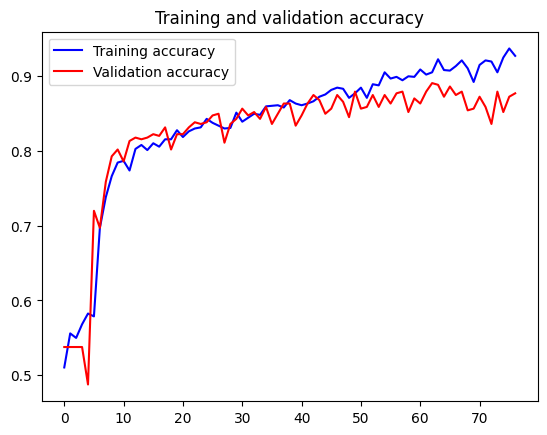

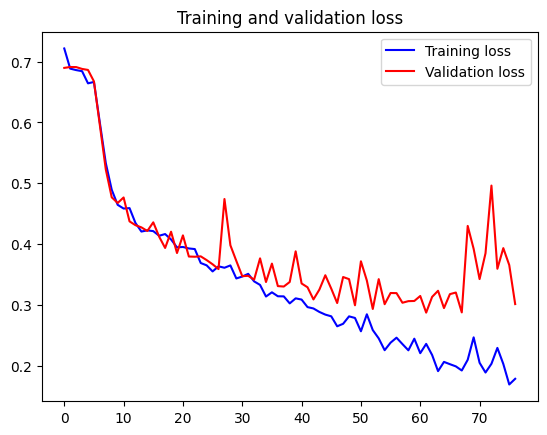

In [ ]:
results = model.evaluate(X_val, y_val)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## Salvamento do modelo

In [ ]:
model.save('saved_model.h5')

!mkdir -p saved_model
model.save('saved_model/my_model')

!zip -r model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 90%)
  adding: saved_model/my_model/fingerprint.pb (stored 0%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 91%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: saved_model/my_model/variables/variables.index (deflated 62%)


## Predição com dados novos

In [ ]:
# evaluating with new data

# y_t = model.predict(X)
# quant = X.shape[0]
# correct_predictions = 0

# correct = 0

# for i in range(quant):
#   predicted_label = 0 if y_t[i] <= 0.5 else 1
#   true_label = y[i]

#   if true_label == predicted_label:
#     correct += 1

# # Compute accuracy
# accuracy = correct / quant
# print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
# y_t = model.predict(X)
# y_t

In [ ]:
# loading the trained model

!unzip model_70.zip

Archive:  model_70.zip
   creating: saved_model/
   creating: saved_model/my_model/
 extracting: saved_model/my_model/fingerprint.pb  
  inflating: saved_model/my_model/keras_metadata.pb  
   creating: saved_model/my_model/assets/
  inflating: saved_model/my_model/saved_model.pb  
   creating: saved_model/my_model/variables/
  inflating: saved_model/my_model/variables/variables.data-00000-of-00001  
  inflating: saved_model/my_model/variables/variables.index  


## Otimização do modelo

In [ ]:
def representative_dataset():
    for _ in range(100):
      data = np.random.randint(low=0, high=256, size=(1, 112, 112, 1))
      yield [data.astype(np.float32)]

In [ ]:
saved_model_dir = 'saved_model/my_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

# Save the model.
with open('model_quantized.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [ ]:
!xxd -i model_quantized.tflite > model_data.cc

In [ ]:
!ls -lh | grep model

-rw-r--r-- 1 root root 417K May 23 17:49 model_data.cc
-rw-r--r-- 1 root root  68K May 23 17:49 model_quantized.tflite
-rw-r--r-- 1 root root 692K May 23 17:49 model.zip
drwxr-xr-x 3 root root 4.0K May 23 17:49 saved_model
-rw-r--r-- 1 root root 751K May 23 17:49 saved_model.h5


## Avaliação do modelo otimizado

In [ ]:
# !rm -rf saved_model

In [ ]:
img = 0

# Load the TFLite model
model_path = 'model_quantized.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get the input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load your test dataset
test_data = (X * 127).astype(np.int8)
test_labels = y

# Prepare variables for evaluation
total_samples = test_data.shape[0]
correct_predictions = 0

# Run inference on each test sample and compute accuracy
for i in range(total_samples):
    # Get input sample
    input_data = np.reshape(test_data[i], (1, 112, 112, 1))

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    output_scale, output_zero_point = output_details[0]['quantization']
    output = (output_data.astype(float) - output_zero_point) * output_scale
    # Compare the predicted label with the ground truth
    predicted_label = 0 if output < 0.3 else 1

    if predicted_label == 1:
      img = input_data
      break
    
    true_label = test_labels[i]
    if true_label == predicted_label:
        correct_predictions += 1

# Compute accuracy
accuracy = correct_predictions / total_samples
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 0.00%


In [ ]:
img_arr = np.squeeze(img)
# Convert the array to a grayscale image
image = Image.fromarray(img_arr.astype(np.uint8))

# Get the non-zero region of the image
bbox = image.getbbox()

# Crop the image to remove borders
image = image.crop(bbox)

# Save the grayscale image
image.save('grayscale_image.png')

In [ ]:
import base64

# Read the PNG image file
with open('grayscale_image.png', 'rb') as file:
    image_data = file.read()

# Encode the image data as base64
base64_data = base64.b64encode(image_data)

# Convert the base64 data to a C/C++ array
c_array = ', '.join(map(str, base64_data))

# Create the .h file and write the C/C++ array
with open('image.h', 'w') as file:
    file.write('unsigned char image[] = {' + c_array + '};\n')
    file.write('unsigned int image_size = ' + str(len(base64_data)) + ';\n')

## Representação gráfica do modelo

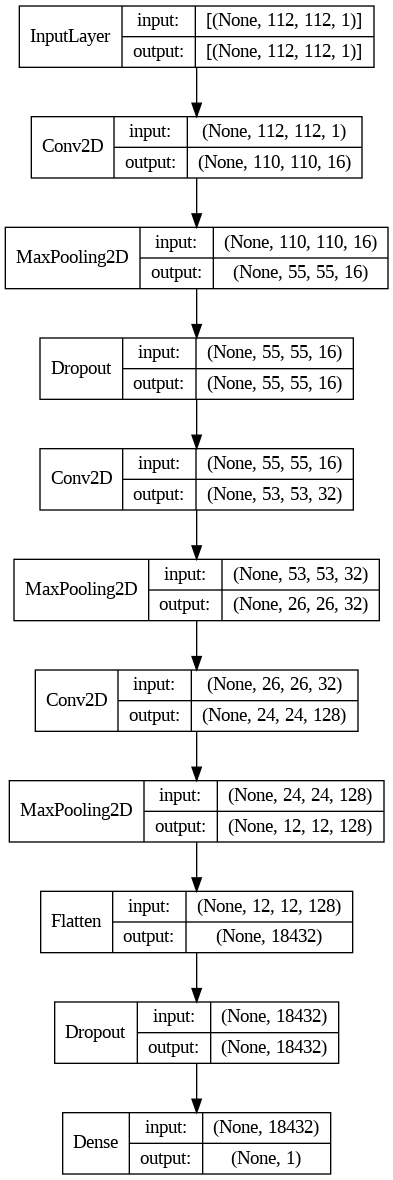

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False)